<a href="https://colab.research.google.com/github/paolanustes/thesis/blob/main/Final_Img_classif_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input dataset pipeline for dams' detection models


# Import external resources

## Install and import main libraries

References https://github.com/giswqs/geemap 

In [ ]:
# !pip -q install qiskit

In [ ]:
!pip -q install -U geemap
!pip -q install geopandas shapely

     |████████████████████████████████| 409kB 5.7MB/s 
     |████████████████████████████████| 1.2MB 10.4MB/s 
     |████████████████████████████████| 143kB 20.5MB/s 
     |████████████████████████████████| 2.5MB 25.4MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 225kB 33.5MB/s 
     |████████████████████████████████| 5.1MB 49.2MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 1.3MB 54.9MB/s 
     |████████████████████████████████| 122kB 36.8MB/s 
     |████████████████████████████████| 112kB 55.0MB/s 
     |████████████████████████████████| 245kB 39.8MB/s 
     |████████████████████████████████| 552kB 53.1MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.12.1 which is incompatible.
ERR

In [ ]:
import ee
import geemap.eefolium as geemap
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=XYKa2PIGHB6hwmPjfybpBOIIh14fNw85GLUznreEr-w&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g4jlsvhmsGitteDEza_EkTvnGbQfvE3km8DOAH29ZrG8AUij_E9bFI

Successfully saved authorization token.


In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive') #To access google drive folders
GDRIVE='/content/drive/MyDrive/Thesis'

Mounted at /content/drive


In [ ]:
from shapely.geometry import Point
from shapely.geometry import CAP_STYLE
from pandas import json_normalize
import requests
import pandas as pd
import geopandas
import csv
import sys

## Add Earth Engine data (Control group: California, USA)

1.   Satellite imagery NAIP https://www.fsa.usda.gov/programs-and-services/aerial-photography/imagery-programs/naip-imagery/
2.   Digital Elevation Model NED https://www.usgs.gov/core-science-systems/national-geospatial-program/national-map
3. Boundaries by state TIGER https://www.census.gov/programs-surveys/geography/guidance/tiger-data-products-guide.html
4. Water occurrence JRC http://global-surface-water.appspot.com/ 
5. Continent's boundaries users/gena/land_polygons_image 






In [ ]:
#Create an interactive map
Map = geemap.Map()

In [ ]:
#input number you want to search
state = input('Enter state postal code: (Example for california enter CA)\n')

#read csv, and split on "," the line
csv_file = csv.reader(open(f'{GDRIVE}/FIPS.csv', "r"), delimiter=",")


#loop through the csv list
for row in csv_file:
    #if current rows 2nd value is equal to input, print that row
    if state == row[1]:
         print (row[2])
         FIP = row[2]

Enter state postal code: (Example for california enter CA)
CA
06


In [ ]:
#Add control polygon of California //  https://datadrivenlab.org/big-data-2/google-earth-engine-tutorial/
# Load US county dataset.
countyData = ee.FeatureCollection('TIGER/2018/Counties').filter(ee.Filter.eq('STATEFP', FIP))

# Get the union of all the county geometries in the county.
control = countyData.union(100).geometry().bounds(100)

#Add Earth Engine dataset (NAIP)
naip = ee.ImageCollection("USDA/NAIP/DOQQ").filterDate('2016-01-01','2019-01-01')
naip1= naip.median().clip(control);
Map.addLayer(naip1, {}, "NAIP");

# Center the map based on coordinates 
Map.setCenter(-120.08, 36.86)

In [ ]:
#Add water ocurrence map to see the water bodies
water = ee.Image("JRC/GSW1_2/GlobalSurfaceWater").select('occurrence').clip(control)
water = water.selfMask()


In [ ]:
#Add DEM
DEM = ee.Image("USGS/NED").clip(control)
aspect = ee.Terrain.aspect(DEM)
slope  =ee.Terrain.slope(DEM)


In [ ]:
#Add continents' boundaries to delete polygons on the coastline
continents = ee.Image("users/gena/land_polygons_image")

In [ ]:
# https://developers.google.com/earth-engine/guides/image_visualization 

ndwi = naip1.normalizedDifference(['N','G']).rename(['ndwi'])

# To mask the non-watery parts of the image, where NDWI < 0.3
ndwiMasked = ndwi.updateMask(ndwi.gte(0.3))

#  Create visualization layers.
imageRGB = naip1.visualize({'bands': ['R', 'G', 'B'], max: 0.5})
ndwiRGB = ndwiMasked.visualize({
  'min': 0.5,
  'max': 1,
  'palette': ['00FFFF', '0000FF']
});

# Mosaic the visualization layers and display (or export)
# mosaic = ee.ImageCollection([imageRGB, ndwiRGB]).mosaic()


## Normalized channels

In [ ]:
SCALE = 10
DEMminMax = DEM.reduceRegion(
  reducer= ee.Reducer.minMax(),
  geometry= DEM.geometry(),
  scale= SCALE,
  maxPixels= 10e12
  )

ndwiminMax = ndwi.reduceRegion(
  reducer= ee.Reducer.minMax(),
  geometry= ndwi.geometry(),
  scale= SCALE,
  maxPixels= 10e12
  )

waterminMax = water.reduceRegion(
  reducer= ee.Reducer.minMax(),
  geometry= water.geometry(),
  scale= SCALE,
  maxPixels= 10e12
  )

AspectminMax = aspect.reduceRegion(
  reducer= ee.Reducer.minMax(),
  geometry= aspect.geometry(),
  scale= SCALE,
  maxPixels= 10e12
  )

SlopeminMax = slope.reduceRegion(
  reducer= ee.Reducer.minMax(),
  geometry= slope.geometry(),
  scale= SCALE,
  maxPixels= 10e12
  )

In [ ]:
norm_DEM = DEM.unitScale(ee.Number(DEMminMax.get('elevation_min')), ee.Number(DEMminMax.get('elevation_max'))).double()
norm_ndwi = ndwi.unitScale(ee.Number(ndwiminMax.get('ndwi_min')), ee.Number(ndwiminMax.get('ndwi_max'))).double()
norm_water = water.unitScale(ee.Number(waterminMax.get('occurrence_min')), ee.Number(waterminMax.get('occurrence_max'))).double() 
norm_aspect = aspect.unitScale(ee.Number(AspectminMax.get('aspect_min')), ee.Number(AspectminMax.get('aspect_max'))).double() 
norm_slope = slope.unitScale(ee.Number(SlopeminMax.get('slope_min')), ee.Number(SlopeminMax.get('slope_max'))).double() 

In [ ]:
#To add the normalized channels as bands in the NAIP image
naip2 = naip1.addBands(norm_ndwi).addBands(norm_water).addBands(norm_aspect).addBands(norm_slope).addBands(norm_DEM)

## Map visualization

In [ ]:
# # Displays the map
# #colors https://en.wikipedia.org/wiki/Web_colors 
# #https://github.com/gee-community/ee-palettes

# Map = geemap.Map()
# Map.setCenter(-120.08, 36.86)
# bounds = Map.get_bounds()

# Map.addLayer(naip1, {}, "NAIP");

# #AOI: Area of interest
# Map.addLayer(control, {'color': 'yellow', 'opacity': 0.5}, "AOI");

# #DEM bands
# hs = ee.Terrain.hillshade(DEM)
# Map.addLayer(hs, {}, 'Elevation hillshade')
# Map.addLayer(aspect, {'min': 0, 'max': 360}, 'Aspect')
# Map.addLayer(slope, {}, 'Slope')

# #Water occurrence
# Map.addLayer(water, { 'min': 0, 'max': 1, 'palette': ['00ffff'] }, 'water')

# #NDWI
# Map.addLayer(ndwi, {'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']}, 'NDWI')
# # ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']
# Map.addLayer(ndwiMasked, {'min': 0.5, 'max': 1, 'palette': ['00FFFF', '0000FF']}, 'NDWI masked')
# # Map.addLayer(mosaic, {}, 'mosaic')

# Map.addLayerControl() 
# Map

# Collect dams' dataset from OpenStreetMap API and NID


## Importing dams locations from OpenStreetMap (Overpass API)
OSM API allows the extraction of data in form of features (node, way, relation). In the following algorithm is carried out the extraction of point locations classified as dams in OSM. 

To create the dam's queries with the right tags: https://taginfo.openstreetmap.org/tags

*Note: the extraction of each type of feature has to be done separetely, otherwise the code selects just one type and the other features are not extracted properly.*

In [ ]:
url = 'http://overpass-api.de/api/interpreter'  # Overpass API URL
query = f"""
[out:json];
area["ISO3166-2"="US-{state}"][admin_level=4];
(node["waterway"="dam"](area);
);
out center;
"""

r = requests.get(url, params={'data': query})
data = r.json()['elements']  # read response as JSON and get the data
df = json_normalize(data).rename(columns={"tags.name":"tag_name"}) #creates a dataframe with the data extracted


In [ ]:
url = 'http://overpass-api.de/api/interpreter'  # Overpass API URL
query2 = f"""
[out:json];
area["ISO3166-2"="US-{state}"][admin_level=4];
( way["waterway"="dam"](area);
);
out center;
"""

r2 = requests.get(url, params={'data': query2})
data2 = r2.json()['elements']  # read response as JSON and get the data
df2 = json_normalize(data2).rename(columns={"center.lat":"lat", "center.lon":"lon", "tags.name":"tag_name"})


**Re-run the code below, sometimes presents error on the first run**

In [ ]:
url = 'http://overpass-api.de/api/interpreter'  # Overpass API URL
query3 = f"""
[out:json];
area["ISO3166-2"="US-{state}"][admin_level=4];
( rel["waterway"="dam"](area);
);
out center;
"""

r3 = requests.get(url, params={'data': query3})
data3 = r3.json()['elements']  # read response as JSON and get the data
df3 = json_normalize(data3).rename(columns={"center.lat":"lat", "center.lon":"lon", "tags.name":"tag_name"})

In [ ]:
#Select the columns of the dataframe
nodes = pd.DataFrame(df, columns=['lat','lon', 'type', 'tag_name'])
ways = pd.DataFrame(df2, columns=['lat','lon', 'type', 'tag_name'])
relations = pd.DataFrame(df3, columns=['lat','lon', 'type', 'tag_name'])

#Append the three features and add index
OSM_dams = nodes.append(ways).append(relations)
OSM_dams["id"] = OSM_dams.index

#Converting the dataframe to .csv file
OSM_dams.to_csv(r'dam_point.csv', encoding='utf-8', index=False)

#Create GeoDataframe of the OSM feature collection
gdf_OSM = geopandas.GeoDataFrame(OSM_dams)

## Importing dams locations from National Inventory of Dams (NID) database

In [ ]:
lines = list()

with open(f'{GDRIVE}/NID.csv', 'r') as readFile:

    reader = csv.reader(readFile)

    for row in reader:

        for field in row:

            if field == state:

                lines.append(row)

with open('mycsv.csv', 'w') as writeFile:

    writer = csv.writer(writeFile)

    writer.writerows(lines)

In [ ]:
data_NID = pd.DataFrame(lines, columns=['RECORDID','LONGITUDE','LATITUDE',
                                        'DAM_TYPE','PURPOSES','DAM_LENGTH','DAM_HEIGHT',
                                        'MAX_STORAGE','SURFACE_AREA','HAZARD','STATE'])
data_NID['LATITUDE']=pd.to_numeric(data_NID['LATITUDE'])
data_NID['LONGITUDE']=pd.to_numeric(data_NID['LONGITUDE'])
data_NID["id"] = data_NID.index

In [ ]:
#Create GeoDataframe of the NID feature collection
gdf_NID=geopandas.GeoDataFrame(data_NID)

## Create earth engine objects to add to the interactive map

In [ ]:
#To convert the dataframe to shape to then create an earth engine object and add the layer to the map

gdf_OSM.set_geometry(
    geopandas.points_from_xy(gdf_OSM['lon'], gdf_OSM['lat']),
    inplace=True, crs='EPSG:4326')
gdf_OSM.drop(['lat', 'lon'], axis=1, inplace=True)  # optional
gdf_OSM.to_file('dams_OSM.shp')

ee_OSM = geemap.shp_to_ee('dams_OSM.shp')

In [ ]:
gdf_NID.set_geometry(
    geopandas.points_from_xy(gdf_NID['LONGITUDE'], gdf_NID['LATITUDE']),
    inplace=True, crs='EPSG:4326')
gdf_NID.drop(['LATITUDE', 'LONGITUDE'], axis=1, inplace=True)  # optional

gdf_NID[~gdf_NID.geometry.is_valid]
gdf_NID = gdf_NID[gdf_NID.geometry.is_valid == True]
gdf_NID.to_file('dams_NID.shp')

ee_NID = geemap.shp_to_ee('dams_NID.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


## Create a polygon with centroid in the imported feature collection (OSM/NID)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


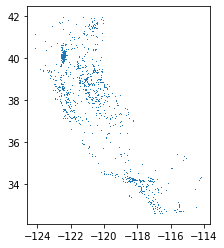

In [ ]:
buffer = gdf_OSM.buffer(0.02, cap_style=3) #0.02 is the dimension in lat/long and cap_style: 1 (round), 2 (flat), 3 (square)
buffer.plot()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


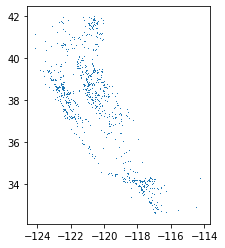

In [ ]:
buffer_NID = gdf_NID.buffer(0.02, cap_style=3)
buffer_NID.plot()

In [ ]:
#From Geoseries to EE object
buf_OSM = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(buffer))
buf_OSM.to_file('buffer_OSMdams.shp')
ee_polygon_OSM = geemap.shp_to_ee('buffer_OSMdams.shp')

buf_NID = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(buffer_NID))
buf_NID.to_file('buffer_NIDdams.shp')
ee_polygon_NID = geemap.shp_to_ee('buffer_NIDdams.shp')


## Map visualization

In [ ]:
# # Displays the map
# Map = geemap.Map()
# Map.setCenter(-120.08, 36.86)
# bounds = Map.get_bounds()

# Map.addLayer(naip1, {}, "NAIP");

# #Add points of OSM and NID feature collections
# Map.addLayer(ee_OSM, {'color': 'yellow'}, 'Dams OSM')
# Map.addLayer(ee_NID, {'color': 'green'}, 'Dams NID')

# #Add unfiltered polygons of OSM and NID dams
# Map.addLayer(ee_polygon_OSM, {'color': 'yellow', 'opacity': 0.5}, 'Polygon_dams_OSM')
# Map.addLayer(ee_polygon_NID, {'color': 'lime', 'opacity': 0.5}, 'Polygon_dams_NID')

# Map.addLayerControl() 
# Map

# Refine the dam dataset 

Remove data that can be noisy 

## Filtering functions

In [ ]:
def compute_water_area(f):
    water2 = water.gt(30)
    Waterarea = ee.Image.pixelArea().mask(water2).reduceRegion(
      reducer= ee.Reducer.sum(), 
      geometry= f.geometry(), 
      scale= SCALE)
  
    return f.set(Waterarea)

In [ ]:
#Function to verify point-in-polygon (pip)
#Retrieved from: https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff 

def get_pip (gdf, polygon):
    id_list = list(polygon.FID)
    #create empty dataframe
    df = pd.DataFrame().reindex_like(gdf).dropna()
    for i in id_list:
        #get geometry for specific region
        pol = (polygon.loc[polygon.FID==i])
        pol.reset_index(drop = True, inplace = True)
        #identify those records from gdf that are intersecting with the region polygon
        pip_mask = gdf.within(pol.loc[0, 'geometry'])
        #filter gdf to keep only the intersecting records
        pip_data = gdf.loc[pip_mask].copy()
        #create a new column and assign the FID as the value
        pip_data['FID']= i
        #append region data to empty dataframe
        df = df.append(pip_data)
        
    #checking there are no more than one region assigned to a point  
    print('Original dataframe count=',len(gdf),'\nNew dataframe count=', len(df))
    if df.loc[df.id.duplicated() == True].shape[0] > 0:
        print("There are id's with more than one region")

    #checking all points have a region
    elif gdf.loc[~gdf.id.isin(df.id)].shape[0] > 0:
        print("There are id's without an assigned region")
    else:
        print("No discrepancies in results!")

    df.reset_index(inplace=True)
    df = df.drop(columns='geometry')
    return df


In [ ]:
def in_land(f):
  isInland = continents.mask().reduceRegion(
      reducer= ee.Reducer.allNonZero(),
      geometry= f.geometry(),
      scale= 30).values().get(0)

  return f.set({'isInland': isInland})


## Filter dam polygons by water area

In [ ]:
### Now we filter the squares for which area does not reach a certain threshold
ee_OSM_Area = ee_polygon_OSM.map(compute_water_area)
ee_NID_Area = ee_polygon_NID.map(compute_water_area)

AreaThreshold = 100000
ee_OSM_water_Filter = ee_OSM_Area.filter(ee.Filter.gt('area', AreaThreshold))
ee_NID_water_Filter = ee_NID_Area.filter(ee.Filter.gt('area', AreaThreshold))

print('All polygons OSM #{}'.format(ee_OSM_Area.size().getInfo()))
print('Filtered polygons OSM by area #{}'.format(ee_OSM_water_Filter.size().getInfo()))

print('All polygons NID #{}'.format(ee_NID_Area.size().getInfo()))
print('Filtered polygons NID by area #{}'.format(ee_NID_water_Filter.size().getInfo()))


All polygons OSM #2266
Filtered polygons OSM by area #962
All polygons NID #1573
Filtered polygons NID by area #830


In [ ]:
# # Displays the map
# Map = geemap.Map()
# Map.setCenter(-120.08, 36.86)
# bounds = Map.get_bounds()

# Map.addLayer(naip1, {}, "NAIP");

# #Add unfiltered polygons of OSM and NID dams
# Map.addLayer(ee_polygon_OSM, {'color': 'red', 'opacity': 0.3}, 'Polygon_dams_OSM')
# Map.addLayer(ee_polygon_NID, {'color': 'red', 'opacity': 0.3}, 'Polygon_dams_NID')

# #Filtered polygons
# Map.addLayer(ee_OSM_water_Filter, {'color': 'blue', 'opacity': 0.6}, 'Waterfilter_dams_OSM')
# Map.addLayer(ee_NID_water_Filter, {'color': 'blue', 'opacity': 0.6}, 'Waterfilter_dams_NID')

# Map.addLayer(water, { 'min': 0, 'max': 1, 'palette': ['aqua'] }, 'water')

# Map.addLayerControl() 
# Map

## Verify at least one point from each feature collection (OSM/NID) within the polygon

In [ ]:
#Convert GEE feature to Geodataframe
poly_OSM = geopandas.GeoDataFrame.from_features(ee_OSM_water_Filter.getInfo())
poly_NID = geopandas.GeoDataFrame.from_features(ee_NID_water_Filter.getInfo())


In [ ]:
poly_OSM.drop(columns='area', inplace=True)
poly_NID.drop(columns='area', inplace=True)

In [ ]:
points_OSM = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(poly_OSM.centroid))
points_NID = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(poly_NID.centroid))
points_OSM['id'] = points_OSM.index
points_NID['id'] = points_NID.index
points_OSM['num'] = points_OSM.index+7800
points_NID['num'] = points_NID.index+6500

In [ ]:
# Points of OSM in squares of NID
pip_filter1 = get_pip(points_OSM, poly_NID)

# Points of NID in squares of OSM
pip_filter2 = get_pip(points_NID, poly_OSM)

Original dataframe count= 962 
New dataframe count= 1420
There are id's with more than one region
Original dataframe count= 830 
New dataframe count= 1420
There are id's with more than one region


In [ ]:
filtered_NID = pip_filter1.drop_duplicates('FID').drop_duplicates('id').merge(poly_NID, how='inner', on='FID')


In [ ]:
filtered_OSM = pip_filter2.drop_duplicates('FID').drop_duplicates('id').merge(poly_OSM, how='left', on='FID')

In [ ]:
#From geodataframe to GEE features
gdf_filtered_NID = geopandas.GeoDataFrame(filtered_NID)
gdf_filtered_OSM = geopandas.GeoDataFrame(filtered_OSM)
gdf_filtered_NID.to_file('filter_NID.shp')
gdf_filtered_OSM.to_file('filter_OSM.shp')
ee_filtered_NID = geemap.shp_to_ee('filter_NID.shp')
ee_filtered_OSM = geemap.shp_to_ee('filter_OSM.shp')


/usr/local/lib/python3.7/dist-packages/geemap/common.py:6659: UserWarning: The projection file /content/filter_NID.prj could not be found. Assuming the dataset is in a geographic coordinate system (GCS).
  f"The projection file {in_prj} could not be found. Assuming the dataset is in a geographic coordinate system (GCS)."
/usr/local/lib/python3.7/dist-packages/geemap/common.py:6659: UserWarning: The projection file /content/filter_OSM.prj could not be found. Assuming the dataset is in a geographic coordinate system (GCS).
  f"The projection file {in_prj} could not be found. Assuming the dataset is in a geographic coordinate system (GCS)."


In [ ]:
# # Displays the map
# Map = geemap.Map()
# Map.setCenter(-120.08, 36.86)
# bounds = Map.get_bounds()

# Map.addLayer(naip1, {}, "NAIP");

# #Filtered polygons
# Map.addLayer(ee_OSM_water_Filter, {'color': 'red', 'opacity': 0.3}, 'Waterfilter_dams_OSM')
# Map.addLayer(ee_NID_water_Filter, {'color': 'red', 'opacity': 0.3}, 'Waterfilter_dams_NID')

# #2nd filter
# Map.addLayer(ee_filtered_OSM, {'color': 'blue', 'opacity': 0.6}, 'Filter2_dams_OSM')
# Map.addLayer(ee_filtered_NID, {'color': 'blue', 'opacity': 0.6}, 'Filter2_dams_NID')

# Map.addLayer(water, { 'min': 0, 'max': 1, 'palette': ['aqua'] }, 'water')

# Map.addLayerControl() 
# Map

## Delete polygons on the coastline

In [ ]:
ee_NID_final = ee_filtered_NID.map(in_land).filter(ee.Filter.eq('isInland', 1))
ee_OSM_final = ee_filtered_OSM.map(in_land).filter(ee.Filter.eq('isInland', 1))

print(ee_NID_final.aggregate_array('isInland').getInfo())
print(ee_OSM_final.aggregate_array('isInland').getInfo())

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
ee_dam_images = ee_NID_final.merge(ee_OSM_final)

In [ ]:
# # Displays the map
# Map = geemap.Map()
# Map.setCenter(-120.08, 36.86)
# bounds = Map.get_bounds()

# Map.addLayer(naip1, {}, "NAIP");

# #2nd filter
# Map.addLayer(ee_filtered_OSM, {'color': 'red', 'opacity': 0.3}, 'Filter2_dams_OSM')
# Map.addLayer(ee_filtered_NID, {'color': 'red', 'opacity': 0.3}, 'Filter2_dams_NID')

# #Final patches
# Map.addLayer(ee_dam_images, {'color': 'blue', 'opacity': 0.8}, 'Final_dams')

# Map.addLayer(water, { 'min': 0, 'max': 1, 'palette': ['aqua'] }, 'water')

# Map.addLayerControl() 
# Map

# Collect negative images (No dam) dataset 
To produce the negative images (non-dam) the dataset is build using bridge locations (since are linear structures that can be mistaken for dams), lakes and random points

In [ ]:
random_points = ee.FeatureCollection.randomPoints(
    region= control,
    points= 150,
    seed= 1234
)

random_points = geopandas.GeoDataFrame.from_features(random_points.getInfo())
random_points["id"] = random_points.index

In [ ]:
url = 'http://overpass-api.de/api/interpreter'  # Overpass API URL
query = f"""
[out:json];
area["ISO3166-2"="US-{state}"][admin_level=4];
(way["bridge"="yes"](area);
);
out center;
"""

rb = requests.get(url, params={'data': query})
data_b = rb.json()['elements']  # read response as JSON and get the data
df_b = json_normalize(data_b).rename(columns={"center.lat":"lat", "center.lon":"lon"})


In [ ]:
url = 'http://overpass-api.de/api/interpreter'  # Overpass API URL
query = f"""
[out:json];
area["ISO3166-2"="US-{state}"][admin_level=4];
(way["water"="lake"](area);
 way["natural"="water"](area);
);
out center;
"""

rl = requests.get(url, params={'data': query})
data_l = rl.json()['elements']  # read response as JSON and get the data
df_l = json_normalize(data_l).rename(columns={"center.lat":"lat", "center.lon":"lon"})

In [ ]:
bridges = pd.DataFrame(df_b, columns=['lat','lon', 'id'])
bridges.to_csv(r'osm_bridge.csv', encoding='utf-8', index=False)

lakes = pd.DataFrame(df_l, columns=['lat','lon', 'id'])
lakes.to_csv(r'osm_lake.csv', encoding='utf-8', index=False)

In [ ]:
gdf_bridge = geopandas.GeoDataFrame(bridges)

#To convert the dataframe to shape to then create an earth engine object and add the layer to the map
gdf_bridge.set_geometry(
    geopandas.points_from_xy(gdf_bridge['lon'], gdf_bridge['lat']),
    inplace=True, crs='EPSG:4326')
gdf_bridge.drop(['lat', 'lon'], axis=1, inplace=True)  # optional
gdf_bridge.to_file('bridges_osm.shp')

In [ ]:
gdf_lake = geopandas.GeoDataFrame(lakes)

#To convert the dataframe to shape to then create an earth engine object and add the layer to the map
gdf_lake.set_geometry(
    geopandas.points_from_xy(gdf_lake['lon'], gdf_lake['lat']),
    inplace=True, crs='EPSG:4326')
gdf_lake.drop(['lat', 'lon'], axis=1, inplace=True)  # optional
gdf_lake.to_file('lakes_osm.shp')

# Refine no dam dataset

To make the no-dam images more representative for the model to learn

In [ ]:
N=len(buf_OSM)
buf_OSM['FID'] = buf_OSM.index
buf_NID['FID'] = buf_NID.index+N

In [ ]:
# dams_NID = geopandas.GeoDataFrame.from_features(ee_NID_final.getInfo())
# dams_OSM = geopandas.GeoDataFrame.from_features(ee_OSM_final.getInfo())
# dams_NID = dams_NID.drop(columns= {'num', 'id', 'index', 'isInland'})
# dams_OSM = dams_OSM.drop(columns= {'FID', 'id', 'index', 'isInland'}).rename(columns={"num": "FID"})

In [ ]:
total_dams = buf_OSM.append(buf_NID)

In [ ]:
lake_filter = get_pip(gdf_lake, total_dams)
bridge_filter = get_pip(gdf_bridge, total_dams)
random_filter = get_pip(random_points, total_dams)

Original dataframe count= 2362 
New dataframe count= 1014
There are id's with more than one region
Original dataframe count= 43473 
New dataframe count= 17247
There are id's with more than one region
Original dataframe count= 150 
New dataframe count= 17
There are id's with more than one region


In [ ]:
if lake_filter['id'].count() == 0:
  lakes_gdf = gdf_lake
else:
  indx = []
  for i in lake_filter['index']:
    indx.append(i)
  lakes_gdf = gdf_lake.drop(indx, axis=0)


In [ ]:
lakes_gdf = lakes_gdf.sample(1000, random_state=1234)
lakes_gdf.to_file('lake_filter.shp')
ee_lakes = geemap.shp_to_ee('lake_filter.shp')
lakes_buffer = lakes_gdf.buffer(0.02, cap_style=3)
lakes_buf = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(lakes_buffer))
lakes_buf.to_file('lakes.shp')
ee_lakes_pol = geemap.shp_to_ee('lakes.shp')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [ ]:
if bridge_filter['id'].count() == 0:
  bridge_gdf = gdf_bridge
else:
  indx_b = []
  for i in bridge_filter['index']:
    indx_b.append(i)
  bridge_gdf = gdf_bridge.drop(indx_b, axis=0)

In [ ]:
bridge_gdf = bridge_gdf.sample(3000, random_state=1234)
bridge_gdf.to_file('bridge_filter.shp')
ee_bridge = geemap.shp_to_ee('bridge_filter.shp')
bridge_buffer = bridge_gdf.buffer(0.02, cap_style=3)
bridge_buf = geopandas.GeoDataFrame(geometry=geopandas.GeoSeries(bridge_buffer))
bridge_buf.to_file('bridges.shp')
ee_bridge_pol = geemap.shp_to_ee('bridges.shp')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


In [ ]:
if random_filter['id'].count() == 0:
  random_gdf = random_points
else:
  indx_r = []
  for i in random_filter['index']:
    indx_r.append(i)
  random_gdf = random_points.drop(indx_r, axis=0)

In [ ]:
random_gdf.to_file('random_filter.shp')
ee_random_p = geemap.shp_to_ee('random_filter.shp')
random_buffer = random_gdf.buffer(0.02, cap_style=3)
random_buffer.to_file('random_rects.shp')
ee_random = geemap.shp_to_ee('random_rects.shp')

/usr/local/lib/python3.7/dist-packages/geemap/common.py:6659: UserWarning: The projection file /content/random_filter.prj could not be found. Assuming the dataset is in a geographic coordinate system (GCS).
  f"The projection file {in_prj} could not be found. Assuming the dataset is in a geographic coordinate system (GCS)."
/usr/local/lib/python3.7/dist-packages/geemap/common.py:6659: UserWarning: The projection file /content/random_rects.prj could not be found. Assuming the dataset is in a geographic coordinate system (GCS).
  f"The projection file {in_prj} could not be found. Assuming the dataset is in a geographic coordinate system (GCS)."


## Filter no-dam polygons by water area

In [ ]:
### Now we filter the squares for which area does not reach a certain threshold
ee_bridge_area = ee_bridge_pol.map(compute_water_area)
ee_lakes_area = ee_lakes_pol.map(compute_water_area)

ee_bridge_w = ee_bridge_area.filter(ee.Filter.gt('area', AreaThreshold))
ee_lakes_w = ee_lakes_area.filter(ee.Filter.gt('area', AreaThreshold))

print('All polygons OSM #{}'.format(ee_bridge_pol.size().getInfo()))
print('Filtered polygons OSM by area #{}'.format(ee_bridge_w.size().getInfo()))

print('All polygons OSM #{}'.format(ee_lakes_pol.size().getInfo()))
print('Filtered polygons OSM by area #{}'.format(ee_lakes_w.size().getInfo()))

All polygons OSM #3000
Filtered polygons OSM by area #720
All polygons OSM #1000
Filtered polygons OSM by area #584


# VISUALIZATION

In [ ]:
# # Displays the map
Map = geemap.Map()
Map.setCenter(-120.08, 36.86)
bounds = Map.get_bounds()

Map.addLayer(naip1, {}, "NAIP");

#Final patches
Map.addLayer(ee_dam_images, {'color': 'yellow', 'opacity': 0.8}, 'Final_dams')

Map.addLayer(water, { 'min': 0, 'max': 1, 'palette': ['aqua'] }, 'water')

Map.addLayer(ee_bridge_w, {'color': 'pink', 'opacity': 0.6}, 'bridges')

Map.addLayer(ee_lakes_w, {'color': 'PaleGreen', 'opacity': 0.6}, 'lakes area')

Map.addLayer(ee_random, {'color': 'silver', 'opacity': 0.6}, 'random')

Map.addLayerControl() 
Map

# Export patches as TFRecords to Drive

## Export dam images

In [ ]:
rect_list = ee_dam_images.toList(10000)

count = rect_list.size().getInfo()

SIZE = 440
for i in range(count):
  rect = ee.Feature(rect_list.get(i)).geometry()

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'PatchesExported-%d'%(i),
    fileNamePrefix= 'Dam-%d'%(i),
    folder= 'Dam_CA',
    region= rect,
    scale= SCALE,
    maxPixels=10e12,
    fileFormat= 'TFRecord',
    formatOptions = {
      'patchDimensions': [SIZE, SIZE],
      'compressed': True}
  ).start()

  print('Export Image %d was submitted, please wait ...'%(i))




## Export non-dam images

In [ ]:
random_list = ee_random.toList(100)
bridge_list = ee_bridge_w.toList(400)
lake_list = ee_lakes_w.toList(200)

for i in range(100):

  random = ee.Feature(random_list.get(i)).geometry()

  # // EXPORT PATCHES

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'RandomPatches-%d'%(i),
    fileNamePrefix= 'random-%d'%(i),
    scale= SCALE,
    folder= 'No_dam_CA_2',
    fileFormat= 'TFRecord',
    region= random,
    formatOptions = {
      'patchDimensions': [SIZE, SIZE],
      'compressed': True}
  ).start()

  print('Export Random Image %d was submitted, please wait ...'%(i))



for i in range(400):

  bridges = ee.Feature(bridge_list.get(i)).geometry()

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'RandomPatches-%d'%(i),
    fileNamePrefix= 'bridges-%d'%(i),
    scale= SCALE,
    folder= 'No_dam_CA_2',
    fileFormat= 'TFRecord',
    region= bridges,
    formatOptions = {
      'patchDimensions': [SIZE, SIZE],
      'compressed': True}
  ).start()

  print('Export Bridge Image %d was submitted, please wait ...'%(i))



for i in range(200):

  lakes = ee.Feature(lake_list.get(i)).geometry()

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'RandomPatches-%d'%(i),
    fileNamePrefix= 'lakes-%d'%(i),
    scale= SCALE,
    folder= 'No_dam_CA_2',
    fileFormat= 'TFRecord',
    region= lakes,
    formatOptions = {
      'patchDimensions': [SIZE, SIZE],
      'compressed': True}
  ).start()

  print('Export Lake Image %d was submitted, please wait ...'%(i))



# Export patches as GeoTIFF to Drive

## Export dam images

In [ ]:
rect_list = ee_dam_images.toList(10000)

count = rect_list.size().getInfo()

SIZE = 440
for i in range(308, count):
  rect = ee.Feature(rect_list.get(i)).geometry()

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'PatchesExported-%d'%(i),
    fileNamePrefix= 'Dam-%d'%(i),
    folder= 'Dam_CA_t',
    region= rect,
    scale= SCALE,
    maxPixels=10e12,
    fileFormat= 'GeoTIFF',

  ).start()

  print('Export Image %d was submitted, please wait ...'%(i))



Export Image 308 was submitted, please wait ...
Export Image 309 was submitted, please wait ...
Export Image 310 was submitted, please wait ...
Export Image 311 was submitted, please wait ...
Export Image 312 was submitted, please wait ...
Export Image 313 was submitted, please wait ...
Export Image 314 was submitted, please wait ...
Export Image 315 was submitted, please wait ...
Export Image 316 was submitted, please wait ...
Export Image 317 was submitted, please wait ...
Export Image 318 was submitted, please wait ...
Export Image 319 was submitted, please wait ...
Export Image 320 was submitted, please wait ...
Export Image 321 was submitted, please wait ...
Export Image 322 was submitted, please wait ...
Export Image 323 was submitted, please wait ...
Export Image 324 was submitted, please wait ...
Export Image 325 was submitted, please wait ...
Export Image 326 was submitted, please wait ...
Export Image 327 was submitted, please wait ...
Export Image 328 was submitted, please w

## Export non-dam images

In [ ]:
random_list = ee_random.toList(100)
bridge_list = ee_bridge_w.toList(400)
lake_list = ee_lakes_w.toList(200)

for i in range(100):

  random = ee.Feature(random_list.get(i)).geometry()

  # // EXPORT PATCHES

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'RandomPatches-%d'%(i),
    fileNamePrefix= 'random-%d'%(i),
    scale= SCALE,
    folder= 'No_dam_CA_t',
    fileFormat= 'GeoTIFF',
    region= random,

  ).start()

  print('Export Random Image %d was submitted, please wait ...'%(i))



for i in range(400):

  bridges = ee.Feature(bridge_list.get(i)).geometry()

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'RandomPatches-%d'%(i),
    fileNamePrefix= 'bridges-%d'%(i),
    scale= SCALE,
    folder= 'No_dam_CA_t',
    fileFormat= 'GeoTIFF',
    region= bridges,

  ).start()

  print('Export Bridge Image %d was submitted, please wait ...'%(i))



for i in range(200):

  lakes = ee.Feature(lake_list.get(i)).geometry()

  task = ee.batch.Export.image.toDrive(  
    image= naip2,
    description= 'RandomPatches-%d'%(i),
    fileNamePrefix= 'lakes-%d'%(i),
    scale= SCALE,
    folder= 'No_dam_CA_t',
    fileFormat= 'GeoTIFF',
    region= lakes,

  ).start()

  print('Export Lake Image %d was submitted, please wait ...'%(i))



Export Random Image 0 was submitted, please wait ...
Export Random Image 1 was submitted, please wait ...
Export Random Image 2 was submitted, please wait ...
Export Random Image 3 was submitted, please wait ...
Export Random Image 4 was submitted, please wait ...
Export Random Image 5 was submitted, please wait ...
Export Random Image 6 was submitted, please wait ...
Export Random Image 7 was submitted, please wait ...
Export Random Image 8 was submitted, please wait ...
Export Random Image 9 was submitted, please wait ...
Export Random Image 10 was submitted, please wait ...
Export Random Image 11 was submitted, please wait ...
Export Random Image 12 was submitted, please wait ...
Export Random Image 13 was submitted, please wait ...
Export Random Image 14 was submitted, please wait ...
Export Random Image 15 was submitted, please wait ...
Export Random Image 16 was submitted, please wait ...
Export Random Image 17 was submitted, please wait ...
Export Random Image 18 was submitted, 